In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import mysql.connector
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon,LineString,MultiLineString,LinearRing,Point
from shapely import symmetric_difference
from shapely.ops import nearest_points
from shapely.wkt import loads
import scipy
import time
import numpy as np
import random
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import osmnx as ox
import glob
from itertools import combinations,product
from copy import deepcopy
import os
from lib_contour_lines import *
import mysql.connector
from scipy.optimize import minimize



In [2]:

cnx = mysql.connector.connect(user='spirz', 
                              password='this_is_my_PASSWORD_m8',
                              host='localhost',
                              database='dem_from_contours_lines',
                              autocommit=True)
cursor = cnx.cursor(buffered=True,dictionary=True)
osm_nodes_table_name="osm_nodes"
osm_edges_table_name="osm_edges"
intersections_table_name="intersections"
2

2

In [3]:
t1=time.time()
G_osm=nx.MultiGraph()
cmd="SELECT osm_begin,osm_end,osm_key,length FROM %s WHERE NOT intersects"%osm_edges_table_name
cursor.execute(cmd)
G_osm.add_edges_from([(elem['osm_begin'],elem['osm_end'],elem['osm_key'],{'length':elem['length']}) for elem in cursor.fetchall()])
cmd="SELECT osm_id,ST_asText(geometry) AS geometry FROM %s WHERE osm_id IN %s"%(osm_nodes_table_name,str(tuple(G_osm.nodes())))
cursor.execute(cmd)
data={elem['osm_id']:{'geometry':loads(elem['geometry'])} for elem in cursor.fetchall()}
nx.set_node_attributes(G_osm,{node:{'x':datum['geometry'].x,'y':datum['geometry'].y} for node,datum in data.items()})
t2=time.time()
print(t2-t1)

0.12796306610107422


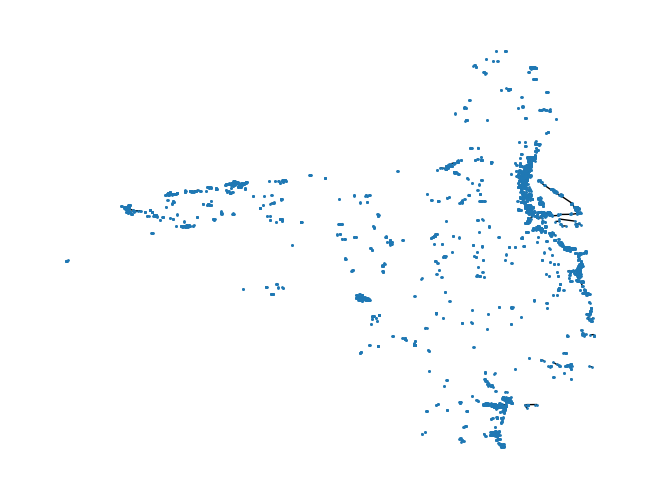

In [4]:
pos={node:(datum['x'],datum['y']) for node,datum in G_osm.nodes(data=True)}
nx.draw(G_osm,pos=pos,node_size=1)

In [5]:
print(len(G_osm.nodes()),len(G_osm.edges()),len(list(nx.connected_components(nx.Graph(G_osm)))),len(nx.cycle_basis(nx.Graph(G_osm))))

4558 4011 1062 487


In [6]:
t1=time.time()
k=0

true_osm_nodes=tuple(G_osm.nodes())
cmd="SELECT osm_begin,osm_end,osm_key,edge_coordinate,elevation,ST_asText(geometry) AS geometry FROM %s WHERE osm_begin IN %s"%(intersections_table_name,str(true_osm_nodes))
cursor.execute(cmd)
intersection=pd.DataFrame(cursor.fetchall())
intersection['geometry']=intersection['geometry'].apply(lambda pt:loads(pt))

for (osm_begin,osm_end,osm_key),df in intersection.groupby(['osm_begin','osm_end','osm_key']):
    df=df.sort_values('edge_coordinate')
    row=df.iloc[0]
    neighbor_pt,neighbor_elevation,length=row['geometry'],row['elevation'],row['edge_coordinate']
    G_osm.add_node((osm_begin,k),x=neighbor_pt.x,y=neighbor_pt.y,elevation=neighbor_elevation)
    G_osm.add_edge(osm_begin,(osm_begin,k),length=length)
    k+=1

cmd="SELECT osm_begin,osm_end,osm_key,length FROM %s WHERE osm_end IN %s"%(osm_edges_table_name,str(true_osm_nodes))
cursor.execute(cmd)
lengths={(elem['osm_begin'],elem['osm_end'],elem['osm_key']):elem['length'] for elem in cursor.fetchall()}

cmd="SELECT osm_begin,osm_end,osm_key,edge_coordinate,elevation,ST_asText(geometry) AS geometry FROM %s WHERE (osm_begin,osm_end,osm_key) IN %s"%(intersections_table_name,str(tuple(lengths.keys())))
cursor.execute(cmd)
intersection=pd.DataFrame(cursor.fetchall())
intersection['geometry']=intersection['geometry'].apply(lambda pt:loads(pt))

for (osm_begin,osm_end,osm_key),df in intersection.groupby(['osm_begin','osm_end','osm_key']):
    df=df.sort_values('edge_coordinate')
    row=df.iloc[-1]
    neighbor_pt,neighbor_elevation,length=row['geometry'],row['elevation'],lengths[(osm_begin,osm_end,osm_key)]-row['edge_coordinate']
    G_osm.add_node((osm_end,k),x=neighbor_pt.x,y=neighbor_pt.y,elevation=neighbor_elevation)
    G_osm.add_edge((osm_end,k),osm_end,length=length)
    k+=1

t2=time.time()
print(t2-t1)

1.335256576538086


In [7]:
t1=time.time()
CC=sorted(list(nx.connected_components(nx.Graph(G_osm))),key=len)
t2=time.time()
print(t2-t1)

0.08122062683105469


In [8]:
count=0
for cc in CC:
    nodes=list(cc)
    variable_indexes=[k for k,node in enumerate(nodes) if not(isinstance(node,tuple))]
    constant_indexes=[k for k,node in enumerate(nodes) if isinstance(node,tuple)]
    elevations=[G_osm.nodes()[nodes[k]]['elevation'] for k in constant_indexes]
    if len(set(elevations))==1:
        count+=1
count

191

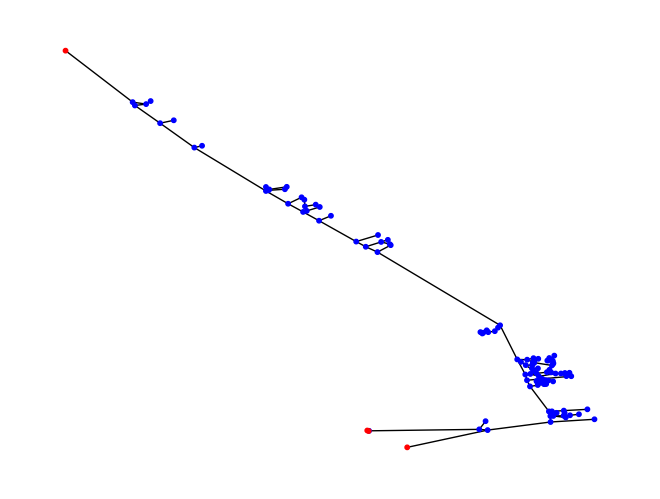

In [9]:
cc=CC[-1]
sub_G_osm=nx.subgraph(G_osm,cc).copy()

pos={node:(datum['x'],datum['y']) for node,datum in sub_G_osm.nodes(data=True)}
node_color=['r' if isinstance(node,tuple)  else 'b' for node in sub_G_osm.nodes()]
nx.draw(sub_G_osm,pos=pos,node_color=node_color,node_size=10)

In [10]:
[data['elevation'] for node,data in sub_G_osm.nodes(data=True) if isinstance(node,tuple)]

[5.0, 5.0, 5.0, 0.0]

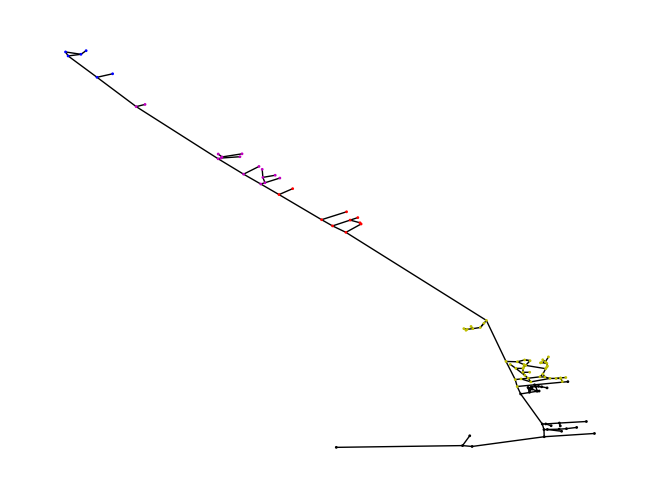

In [11]:
colors=['b','m','r','y','k']
nodes,estimated_elevations=estimate_elevations_from_laplacian(sub_G_osm)
sub_G_osm=nx.subgraph(sub_G_osm,nodes)
integer_elevations=list(np.round(estimated_elevations-np.min(estimated_elevations)).astype('int'))
node_color=[colors[integer_elevation%len(colors)] for integer_elevation in integer_elevations]
nx.draw(sub_G_osm,pos=pos,node_color=node_color,node_size=1)

In [12]:
estimated_elevations

array([0.75467969, 1.88960756, 4.15513704, 1.88977267, 1.88923561,
       4.17078165, 4.17745346, 4.82414024, 4.10867282, 4.15522571,
       4.1551112 , 2.28035802, 1.89025778, 1.89037448, 2.28072636,
       4.53313344, 2.16529314, 4.82361483, 2.16533549, 1.30756535,
       4.16913696, 4.58372022, 4.15591264, 4.15608603, 4.53242357,
       1.30713208, 4.26358114, 4.5329263 , 4.53263531, 4.15574912,
       4.2699215 , 4.15597305, 4.269963  , 4.53251747, 4.15597622,
       4.15599442, 4.49306797, 4.49386677, 4.49391147, 4.4931943 ,
       4.12932576, 4.49267823, 4.26267375, 0.78359209, 1.00352705,
       4.26417106, 1.00316065, 4.16647237, 4.16688623, 4.1561471 ,
       4.99934165, 2.16540574, 4.15621826, 2.16508662, 2.16579829,
       2.05606046, 4.16708177, 4.16702919, 4.16716239, 4.16703084,
       2.16584187, 2.05626776, 2.692722  , 2.69272091, 3.69398756,
       3.69370153, 3.69251888, 3.69403304, 4.53246314, 3.69393519,
       4.81099321, 3.69356474, 3.69340016, 4.58393451, 4.49413

In [13]:
[361.26762162, 361.21161157, 364.95555839, 361.18834282,
       361.21026962]

[361.26762162, 361.21161157, 364.95555839, 361.18834282, 361.21026962]

In [14]:
UPDATE_ELEVATION=True
if UPDATE_ELEVATION:
    t1=time.time()

    for cc in CC:
        sub_G_osm=nx.subgraph(G_osm,cc)
        output=estimate_elevations_from_laplacian(sub_G_osm)
        if output is not None:
            nodes,estimated_elevations=output
            
        cmd="""CREATE TEMPORARY TABLE temp (
        `osm_id` BIGINT NOT NULL,
        `elevation` FLOAT NOT NULL
    
        );"""
        cursor.execute(cmd)
    
        cmd="INSERT INTO temp(`osm_id`,`elevation`) VALUES %s"%',\n'.join(['(%i,%f)'%(node,elevation) for node,elevation in zip(nodes,estimated_elevations)])
        cursor.execute(cmd)
    
        cmd=""" UPDATE %s JOIN temp
        ON %s.osm_id=temp.osm_id
        SET %s.elevation=temp.elevation
    
        ;"""%(osm_nodes_table_name,osm_nodes_table_name,osm_nodes_table_name)
        cursor.execute(cmd)
        
        cmd="DROP TABLE temp"
        cursor.execute(cmd)
    t2=time.time()
    print(t2-t1)





only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one available elevation
only one avail